In [ ]:
from RRI import *
import h5py
from datetime import datetime
import pandas as pd
import numpy as np
import math as mt
from math import sqrt
from scipy.signal import find_peaks
from scipy.signal import argrelextrema,detrend
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import correlate
import pymap3d as pm

# Import the dataset

In [ ]:
fn_ = RRI('RRI_20150401_033844_034241_lv1_12.0.0.h5')

we choose this particular day, April 1, 2015 in our analysis because on this day scintilliaiton was observer high. We use RRI tool box for opening this file https://github.com/GWPerryNJIT/ePOP-RRI. This toolbox gives a list of functions to read and process the data from .h5 files collected by Radio Receiver Instrument (RRI).  

In [ ]:
dir(fn_)

['MGF_data',
 'MLT_',
 'RRI_mono_point',
 'RRI_point',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alt_',
 'd1_freq',
 'd2_freq',
 'data',
 'epop_dt',
 'epop_met',
 'epop_v',
 'epop_x',
 'epop_y',
 'epop_z',
 'filename',
 'fs_',
 'gei_',
 'gei_v',
 'glat_',
 'glon_',
 'gsm_',
 'm1_mV',
 'm2_mV',
 'm3_mV',
 'm4_mV',
 'mlat_',
 'mlon_',
 'pitch_',
 'roll_',
 'yaw_']

We're concerned about the following attributes for our analysis.

In [ ]:
time=fn_.epop_met #time epoc
#monople 1
m1_=fn_.m1_mV #monople 1
m2_=fn_.m2_mV #monople 2
m3_=fn_.m3_mV # monopole 3
m4_=fn_.m4_mV # monopole 4

geo_lat=fn_.glat_ #latitude of satellite
geo_lon=fn_.glon_ # longitude of satellite
alt=fn_.alt_ # altitude of satellite
freq_1=fn_.d1_freq #frequency of signal
fs=fn_.fs_ # sampling frequency which is 62500.33933 for this instrument

## Analysing the attributes

In [ ]:
attributes = {
    'Monopole Voltage 1': m1_,
    'Monopole Voltage 2': m2_,
    'Monopole Voltage 3': m3_,
    'Monopole Voltage 4': m4_,
    'Latitude': geo_lat,
    'Longitude': geo_lon,
    'Altitude': alt,
    'Time': time
}
# dont without time for now
# Header
print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15}".format("Attribute", "Data Type", "Num Entries", "Non-null Values", "Null Values", "NANs"))

# Data rows
for key, value in attributes.items():
    data_type = type(value).__name__
    num_entries = len(value)
    non_null_values = sum(1 for val in value if val is not None)
    num_null_values = num_entries - non_null_values
    nan_values = sum(1 for val in value if isinstance(val, float) and mt.isnan(val))
    print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15}".format(key, data_type, num_entries, non_null_values, num_null_values, nan_values))


Attribute            Data Type       Num Entries     Non-null Values Null Values     NANs           
Monopole Voltage 1   ndarray         14810126        14810126        0               203            
Monopole Voltage 2   ndarray         14810126        14810126        0               116            
Monopole Voltage 3   ndarray         14810126        14810126        0               203            
Monopole Voltage 4   ndarray         14810126        14810126        0               116            
Latitude             ndarray         238             238             0               0              
Longitude            ndarray         238             238             0               0              
Altitude             ndarray         238             238             0               0              
Time                 ndarray         238             238             0               0              


In [ ]:
print('Time : {}, {}, {}'.format(time[0],time[1],len(time)))
print('Frequency : ',freq_1)
print('Sampling Frequency : ',fs)

Time : 1478576324.64053, 1478576325.64053, 238
Frequency :  [17505190.17338658]
Sampling Frequency :  62500.33933


### The elevation angle
It is the angle of the line of sight above the local horizontal at point 1 (where the ray starts). It is calculated using latitude, longitude and altitude of the satellite along with the position of source on ground, which is (52.16,-106.53,494) (latitude, longitude and height in meters). It will have the same number of values as latitude and longitude.    

In [ ]:
elevation=[]
for i in range(len(time)):
          az,el,ran = pm.geodetic2aer(geo_lat[i], geo_lon[i], alt[i]*1000, 52.16,-106.53,494)
          elevation.append(el)

We need to covert time to UTC format for further analysis. Additionally, we need to interpolate  the missing values in order to have a continuous data series. Before that, we need to replace the NaN values with 0 (for now).

In [ ]:
nan_attributes = [m1_, m2_, m3_, m4_]

for attribute in nan_attributes:
          attribute[np.isnan(attribute)] = 0

## Linear Interpolation

In [ ]:
from scipy.interpolate import interp1d

x1 = np.linspace(0,237,num=238,endpoint=True)
y = time
y1 = geo_lat
y2 = geo_lon
y3 = alt
y4 = elevation

f2 = interp1d(x1,y,kind='linear')
f3 = interp1d(x1,y1,kind='linear')
f4 = interp1d(x1,y2,kind='linear')
f5 = interp1d(x1,y3,kind='linear')
f6 = interp1d(x1,y4,kind='linear')

xnew = np.linspace(0,237,num=14810126,endpoint=True)

#these are interpolate data of all parameters
time = f2(xnew)
geo_lat = f3(xnew)
geo_lon = f4(xnew)
alt = f5(xnew)
elev = f6(xnew)

In [ ]:
interpolated_Attributes = {
          'Time' : time,
          'Latitude' : geo_lat,
          'Longitude' : geo_lon,
          'Altitude' : alt,
          'Elev' : elev
}
new_dataFrame = pd.DataFrame(interpolated_Attributes)

### Now, converting Epoc Time to UTC.

In [ ]:
time2=[]
for i in range(len(time)):
    dt_obj1 = pd.to_datetime(time[i], unit='s',origin='1968-05-24')
    time2.append(dt_obj1)
df2 = pd.DataFrame (time2, columns = ['time'])
time_1=pd.to_datetime(df2['time'],format='%Y-%m-%d %H:%M:%S.%f')

# Finding dipole voltage from monopole

In [ ]:
# Before that, we calculate dipole volatge.


diapole_1 = m1_+1j * m2_
diapole_2 = m3_+1j * m4_

v1=abs(diapole_1) #amplitude of diapole 1
v2=abs(diapole_2)  #amplitude of diapole 2

# diapole voltage before removing noise

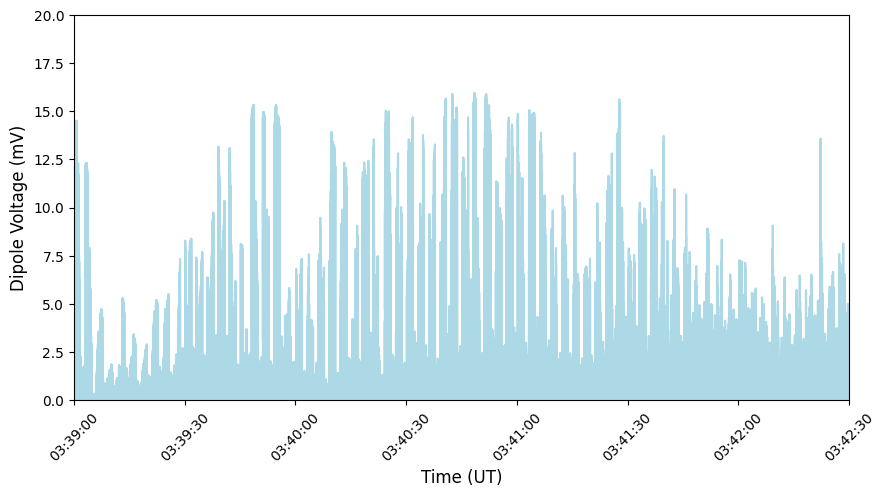

In [ ]:
fig, ax_main = plt.subplots(figsize=(10, 5))

bar1 = ax_main.plot(time_1, v1, color='lightblue')
ax_main.set_xlabel("Time (UT)", fontsize=12)
ax_main.set_ylabel("Dipole Voltage (mV)", fontsize=12)
ax_main.set_ylim(0, 20)
ax_main.set_xlim(left=pd.Timestamp('2015-04-01 03:39:00'),right=pd.Timestamp('2015-04-01 03:42:30'))
plt.tick_params(axis='both', labelsize=10)
ax_main.tick_params(axis='x', labelrotation=45, color='black')

#plt.title("Dipole Voltage before removing noise", fontsize=20)
plt.tick_params(axis='both', labelsize=10)

plt.show()

# Pulse Detection

Super Dual Auroral Radar Network (SuperDARN) site, major source of  HF emission, is at Saskatoon in Canada. Its beam switching period is 1 second for its 15 beams. This radar produces a signal which is filled with noise. We need to filter the pulses from this noise. For that we employ Matched Filter Technique.


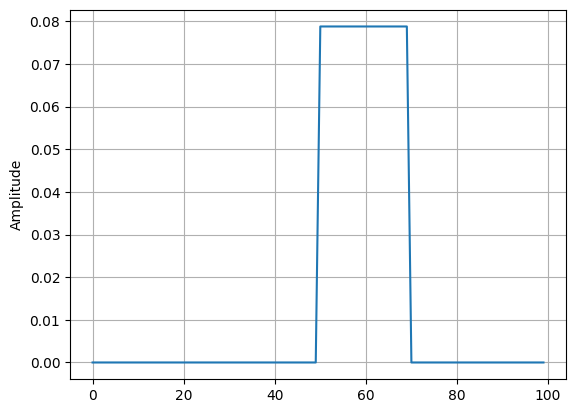

In [ ]:
# Apply matched filter technique to find pulse locations



#matched filter technique to find pulse location.
signal_length = 100

t = np.linspace(0, signal_length, signal_length, endpoint=False)

# Generate square pulse signal
pulse_signal = np.zeros(signal_length)
pulse_signal[50:70] = np.nanquantile(np.abs(v1),0.5)

# Plot the signal
plt.plot(t, pulse_signal)
plt.ylabel('Amplitude')
#plt.title('Generated Signal with Pulse')
plt.grid()
plt.show()
pulse=pulse_signal



### Dividing dipole voltage signals into chucks consisting of 100 data points.

In [ ]:
def divide_chunks(l, n):
          for i in range(0, len(l), n):
                    yield l[i:i + n]


sig_n = list(divide_chunks(v1,100))

# Finding correlation between dummy pulse and each chunk of our dipole voltage

In [ ]:

cof=[]
location=[]
for i in range(len(sig_n)):
          #0.45 is minimum height to identify pulse
          if max(sig_n[i])>0.45:
                    signal = sig_n[i]
                    pulse = pulse_signal
                    p=(pulse - pulse.min()) / (pulse.max() - pulse.min())
                    s=(signal - signal.min()) / (signal.max() - signal.min())
                    corr = correlate(s, p,mode="same",method="fft")
                    xnorm=(corr - corr.min()) / (corr.max() - corr.min())
                    cof.append(xnorm)
                    location.append(i)
position1=[]
position2=[]

for i in range(len(cof)):
          pos1=np.argmax(cof[i])
          pos2=100*location[i]+pos1
          position1.append(pos2)
          position2.append(pos2)

## Correcting pulse Positions
It is needed because the above process may generate two positions for the same pulse.  This can happen if a signal has multiple peaks or troughs within a given set of points.

In [ ]:
#correction of position
pair_pos=[]
pairs = [(position1[i], position1[i+1]) for i in range(len(position1)-1) if abs(position1[i] - position1[i+1]) < 30]
pairs=np.array(pairs)
for i in range(len(pairs)):
          n=np.argmax(v1[pairs[i]])
          pair_pos.append(pairs[i][n])

indices_to_delete = []
data=[]
for i in range(len(position2)-1):
    if abs(position2[i] - position2[i+1]) < 30:
        indices_to_delete.extend([i, i+1])

# Remove the consecutive pairs
data1 = np.delete(position2, indices_to_delete)
data.append(list(data1))
position=sorted(data[0]+pair_pos)


# this is the position of our pulses, for convention
x = np.array(position)

## Getting 50 datapoints on either side of matched pulse to contain the actual pulse

In [ ]:
def from_3d_numpy_to_2d_array(X):
    array_2d = X.reshape(X.shape[0], -1)
    return array_2d


#getting 50 data on either side of pulse position

pulse1=[]
pulse_position=[]
for i in range(len(x)):
                 df_v1=pd.DataFrame(v1)
                 v_1=(df_v1.iloc[x[i]-50:x[i]+50]).reset_index(drop=True)
                 exclude_positions=range(x[i]-20,x[i]+20,1)
                 pulse1.append(v_1)
                 pulse_position.append(exclude_positions)

#converting 3D array into 2D array

g=np.array(pulse1)
n1=from_3d_numpy_to_2d_array(g)
print(n1.shape)

(11009, 100)


# Plotting Dipole Voltage after removing noise

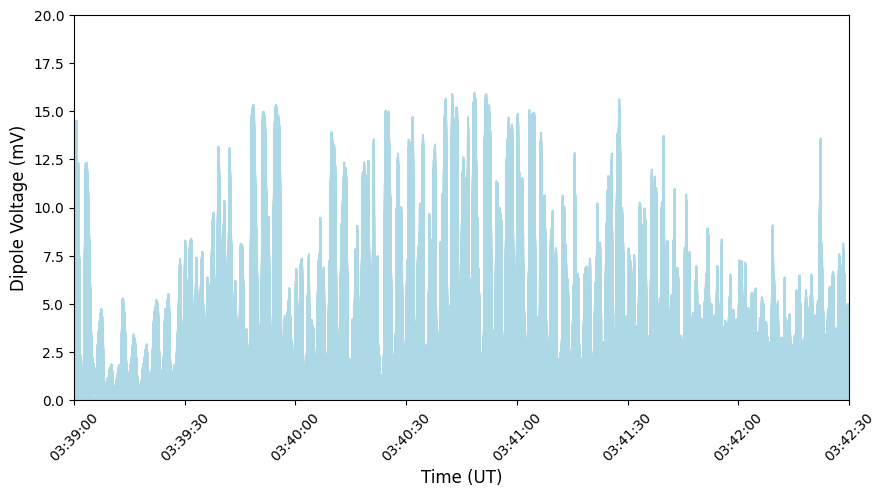

In [ ]:
fig, ax_main = plt.subplots(figsize=(10, 5))

bar1 = ax_main.plot(time_1[x], n1, color='lightblue')
ax_main.set_xlabel("Time (UT)", fontsize=12)
ax_main.set_ylabel("Dipole Voltage (mV)", fontsize=12)
ax_main.set_ylim(0, 20)
ax_main.set_xlim(left=pd.Timestamp('2015-04-01 03:39:00'),right=pd.Timestamp('2015-04-01 03:42:30'))
plt.tick_params(axis='both', labelsize=10)
ax_main.tick_params(axis='x', labelrotation=45, color='black')

#plt.title("Dipole Voltage after removing noise", fontsize=20)
plt.tick_params(axis='both', labelsize=10)

plt.show()

We have 11,009 pulses, each consisting of 100 points.

### Top Max Sum

Choose sets of 10 consecutive data points from each pulse neglecting edges as these edges produce scintillation due to the movement of the beam.

In [ ]:
#finding running sum of data and find the position of maximum sum of set of data
ls=[]
list_new=[]
for k in range(len(n1)):
                 sub_n1=n1[k]
                 for i in range(91):
                                  j=0
                                  sublist=sub_n1[i+j:i+j+10]

                                  #sublist1=np.array(sublist1)
                                  list_new.append(sublist)

In [ ]:
#splititng dataset and finding maximum sum of set of data
list_new=np.array(list_new)
arr2 = np.split(list_new, len(n1), axis=0)
extract=[]
for m in range(len(n1)):
                 nj=arr2[m]
                 sum1=np.sum(nj,axis=1)
                 sum1=np.array(sum1)
                 n0=sum1.argmax()
                 sublist3=nj[n0]
                 extract.append(sublist3)

To mitigate amplitude scintillation resulting from SuperDARN beam switching, we normalize each set of dipole voltage amplitude, which comprises 10 data points representing the corresponding pulse, and compile them into one comprehensive array.


In [ ]:
newextract=[]
for h in range(len(n1)):
                 m=(extract[h]).tolist()
                 newextract.append(m)

consecutive_sets_pos= []

for u in range(len(n1)):
    indices = list(set(i for i, x1 in enumerate(n1[u]) for p, y1 in enumerate(extract[u]) if x1 == y1))
    indices.sort()  # Sort the indices in ascending order

    for i in range(len(indices)-9):
        if indices[i+9] - indices[i] == 9:  # Check if indices are consecutive and there are 10 of them
            consecutive_sets_pos.append(indices[i:i+10])
print("Consecutive sets of indices with 10 elements:", consecutive_sets_pos[:50])

Consecutive sets of indices with 10 elements: [[57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [49, 50, 51, 52, 53, 54, 55, 56, 57, 58], [56, 57, 58, 59, 60, 61, 62, 63, 64, 65], [58, 59, 60, 61, 62, 63, 64, 65, 66, 67], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [58, 59, 60, 61, 62, 63, 64, 65, 66, 67], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [53, 54, 55, 56, 57, 58, 59, 

### Finding the exact time of the pulse

In [ ]:
#creating nan list

a = np.empty((len(n1),100))
a[:] = np.nan
a.tolist()
newa=[]
for k in range(len(n1)):
                 no=(a[k]).tolist()
                 newa.append(no)

for i in range(len(n1)):
                 for k in range(10):
                                  posi=[val for w, val in enumerate(consecutive_sets_pos[i])]
                                  dat=[value for q,value in enumerate(newextract[i])]
                                  newa[i][posi[k]]=dat[k]

#finding intensity of signal
extract2 = np.array(extract)

#this is intensity
extract1 = extract2**2

## Plotting the real pulse (random one)

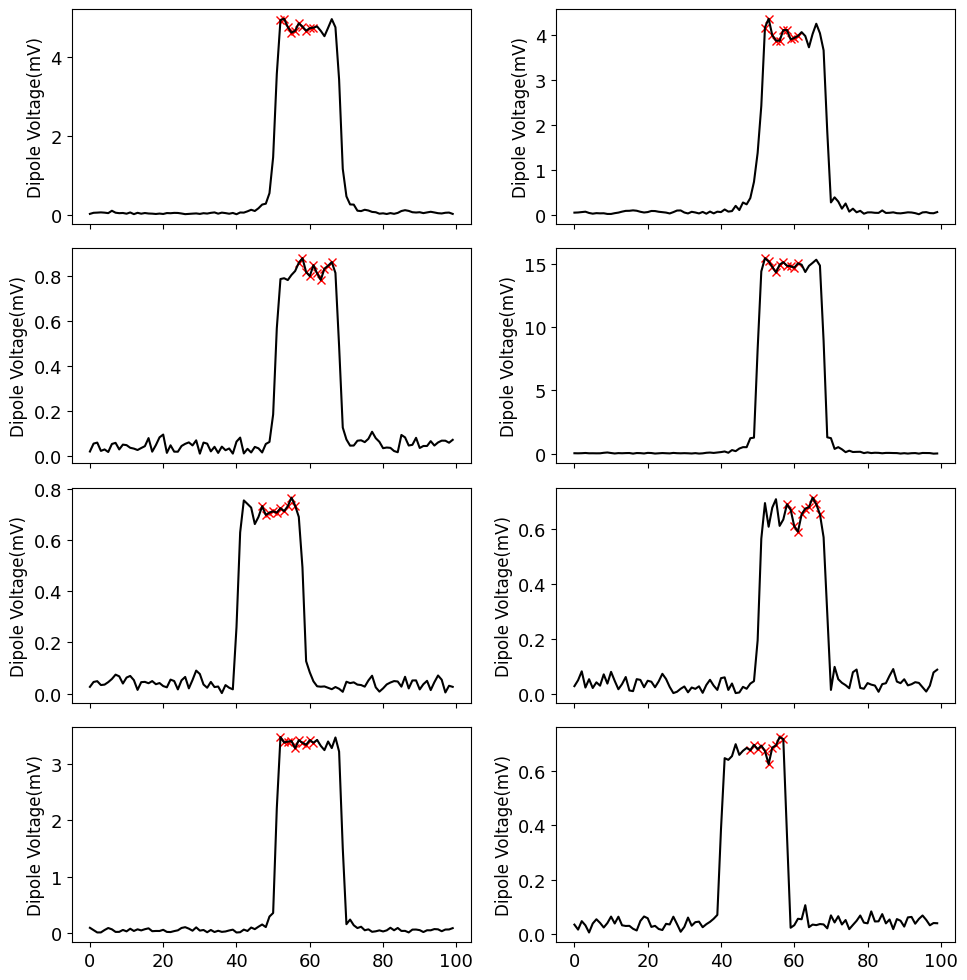

In [ ]:
import matplotlib.pyplot as plt

# Indices to select
indices = [24, 38, 102, 201, 345, 590, 900, 1111]

# Calculate the number of rows and columns needed
num_rows = (len(indices) + 1) // 2  # Round up division
num_cols = 2

# Create a figure and axes for subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10), sharex=True)

# Flatten the axes array if necessary
if num_rows == 1:
    axs = axs.reshape(1, -1)
else:
    axs = axs.flatten()

# Iterate over the selected indices
for i, idx in enumerate(indices):
    row = i // num_cols
    col = i % num_cols
    axs[i].plot(newa[idx], 'x', color='r')  # Plot data from newa with red crosses
    axs[i].plot(n1[idx], color='black')     # Plot data from n1 with black lines
    axs[i].set_ylabel('Dipole Voltage(mV)', fontsize=12)

plt.tight_layout()
plt.show()


With the observation of amplitude veriation  of above pulses we cannot assume where scintillati in the signal present.  To find the scintillation amplitude and location we need to go through futher investigation.

**The red marks on the graph are the 10 data points that we use for calculating S4 index.**

### Using epoch time and converting it into micro seconds to know pulse barrier

In [ ]:
from scipy.interpolate import interp1d
time=fn_.epop_met #time epoc
x1=np.linspace(0,237,num=238,endpoint=True)
y=fn_.epop_met
f2=interp1d(x1,y,kind='linear')
xnew=np.linspace(0,237,num=14810126,endpoint=True)
time=f2(xnew)
time_pulse1=[]
for i in range(len(x)):
                 timeframe=pd.DataFrame(time,index=None)
                 t_1=(timeframe.iloc[x[i]-50:x[i]+50]).reset_index(drop=True)
                 t_2=t_1[0]
                 time_pulse1.append(t_2)
time_pulse1=np.array(time_pulse1)
time_extract = []
time_extract_1 = []

for i in range(len(time_pulse1)):
    c = time_pulse1[i][consecutive_sets_pos[i]]
    d = pd.to_datetime(c, unit='s', origin='1968-05-24')
    d=np.array(d)
    time_extract.append(d)
    c=np.array(c)
    time_extract_1.append(c)
time_extract_1=np.concatenate(time_extract_1)
time_extract_2=np.concatenate(time_extract)
#converting time into dataframe and change the format
df2 = pd.DataFrame (time_extract_2, columns = ['time'])
time_s4_new=pd.to_datetime(df2['time'],format='%Y-%m-%d %H:%M:%S.%f')

real_time=[]
for i in range(len(n1)):
          for j in range(10):
                    time_micro=time_extract_1[i]/10**(-6)
                    #
                    real_time.append(time_micro)


## Normalizing the obtained data and creating 2 columns intensity and time

In [ ]:
def normalize(data):
    x_min = min(data)
    x_max = max(data)
    normalized_data = [(x - x_min) / (x_max - x_min) for x in data]
    return normalized_data
data_ = []
for i in range(len(extract1)):
          norm_dat = normalize(extract1[i])
          norm_dat = np.array(norm_dat)
          data_.append(norm_dat)
data_s4 = np.concatenate(data_)
data_set = pd.DataFrame(data_s4,columns=["Intensity"])
data_set['time'] = time_s4_new

## Running Average of Time

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#dividing out intensity data into time average data

def aggregate_intensity(data, interval_seconds_list):
    # Ensure 'time' column is in datetime format
    data['time'] = pd.to_datetime(data['time'])

    # Set 'time' column as index
    data.set_index('time', inplace=True)

    # Create an empty list to store the results
    result = []

    # Loop through each interval duration
    for interval_seconds in interval_seconds_list:
        # Resample data into specified second intervals and aggregate intensity values as a list
        interval_string = f'{interval_seconds}S'
        df_subset = data['Intensity'].resample(interval_string).apply(list).reset_index()

        # Append the result to the list
        result.append(df_subset)

    return result


interval_seconds=set(range(1, 61))
df_subset_ = aggregate_intensity(data_set, interval_seconds)


# Calculating S4 values of time average data

In [ ]:
#finding s4 of time average data

def calculate_s4(intensity_values):
    s4_values = []
    for i in range(len(intensity_values)):
        intensity = intensity_values[i]
        if np.count_nonzero(intensity) > 0:  # Check if there are non-zero values
            s4 = np.std(intensity) / np.nanmean(intensity)
            s4_values.append(s4)
        else:
            s4_values.append(np.nan)  # Assign NaN if denominator is zero
    return s4_values

In [ ]:
s4_values_all = []

for i in range(60):
    s4_values_i = calculate_s4(df_subset_[i]["Intensity"])
    s4_values_all.append(s4_values_i)

## Amplitude Scintillation(s4) Visualization at different time average

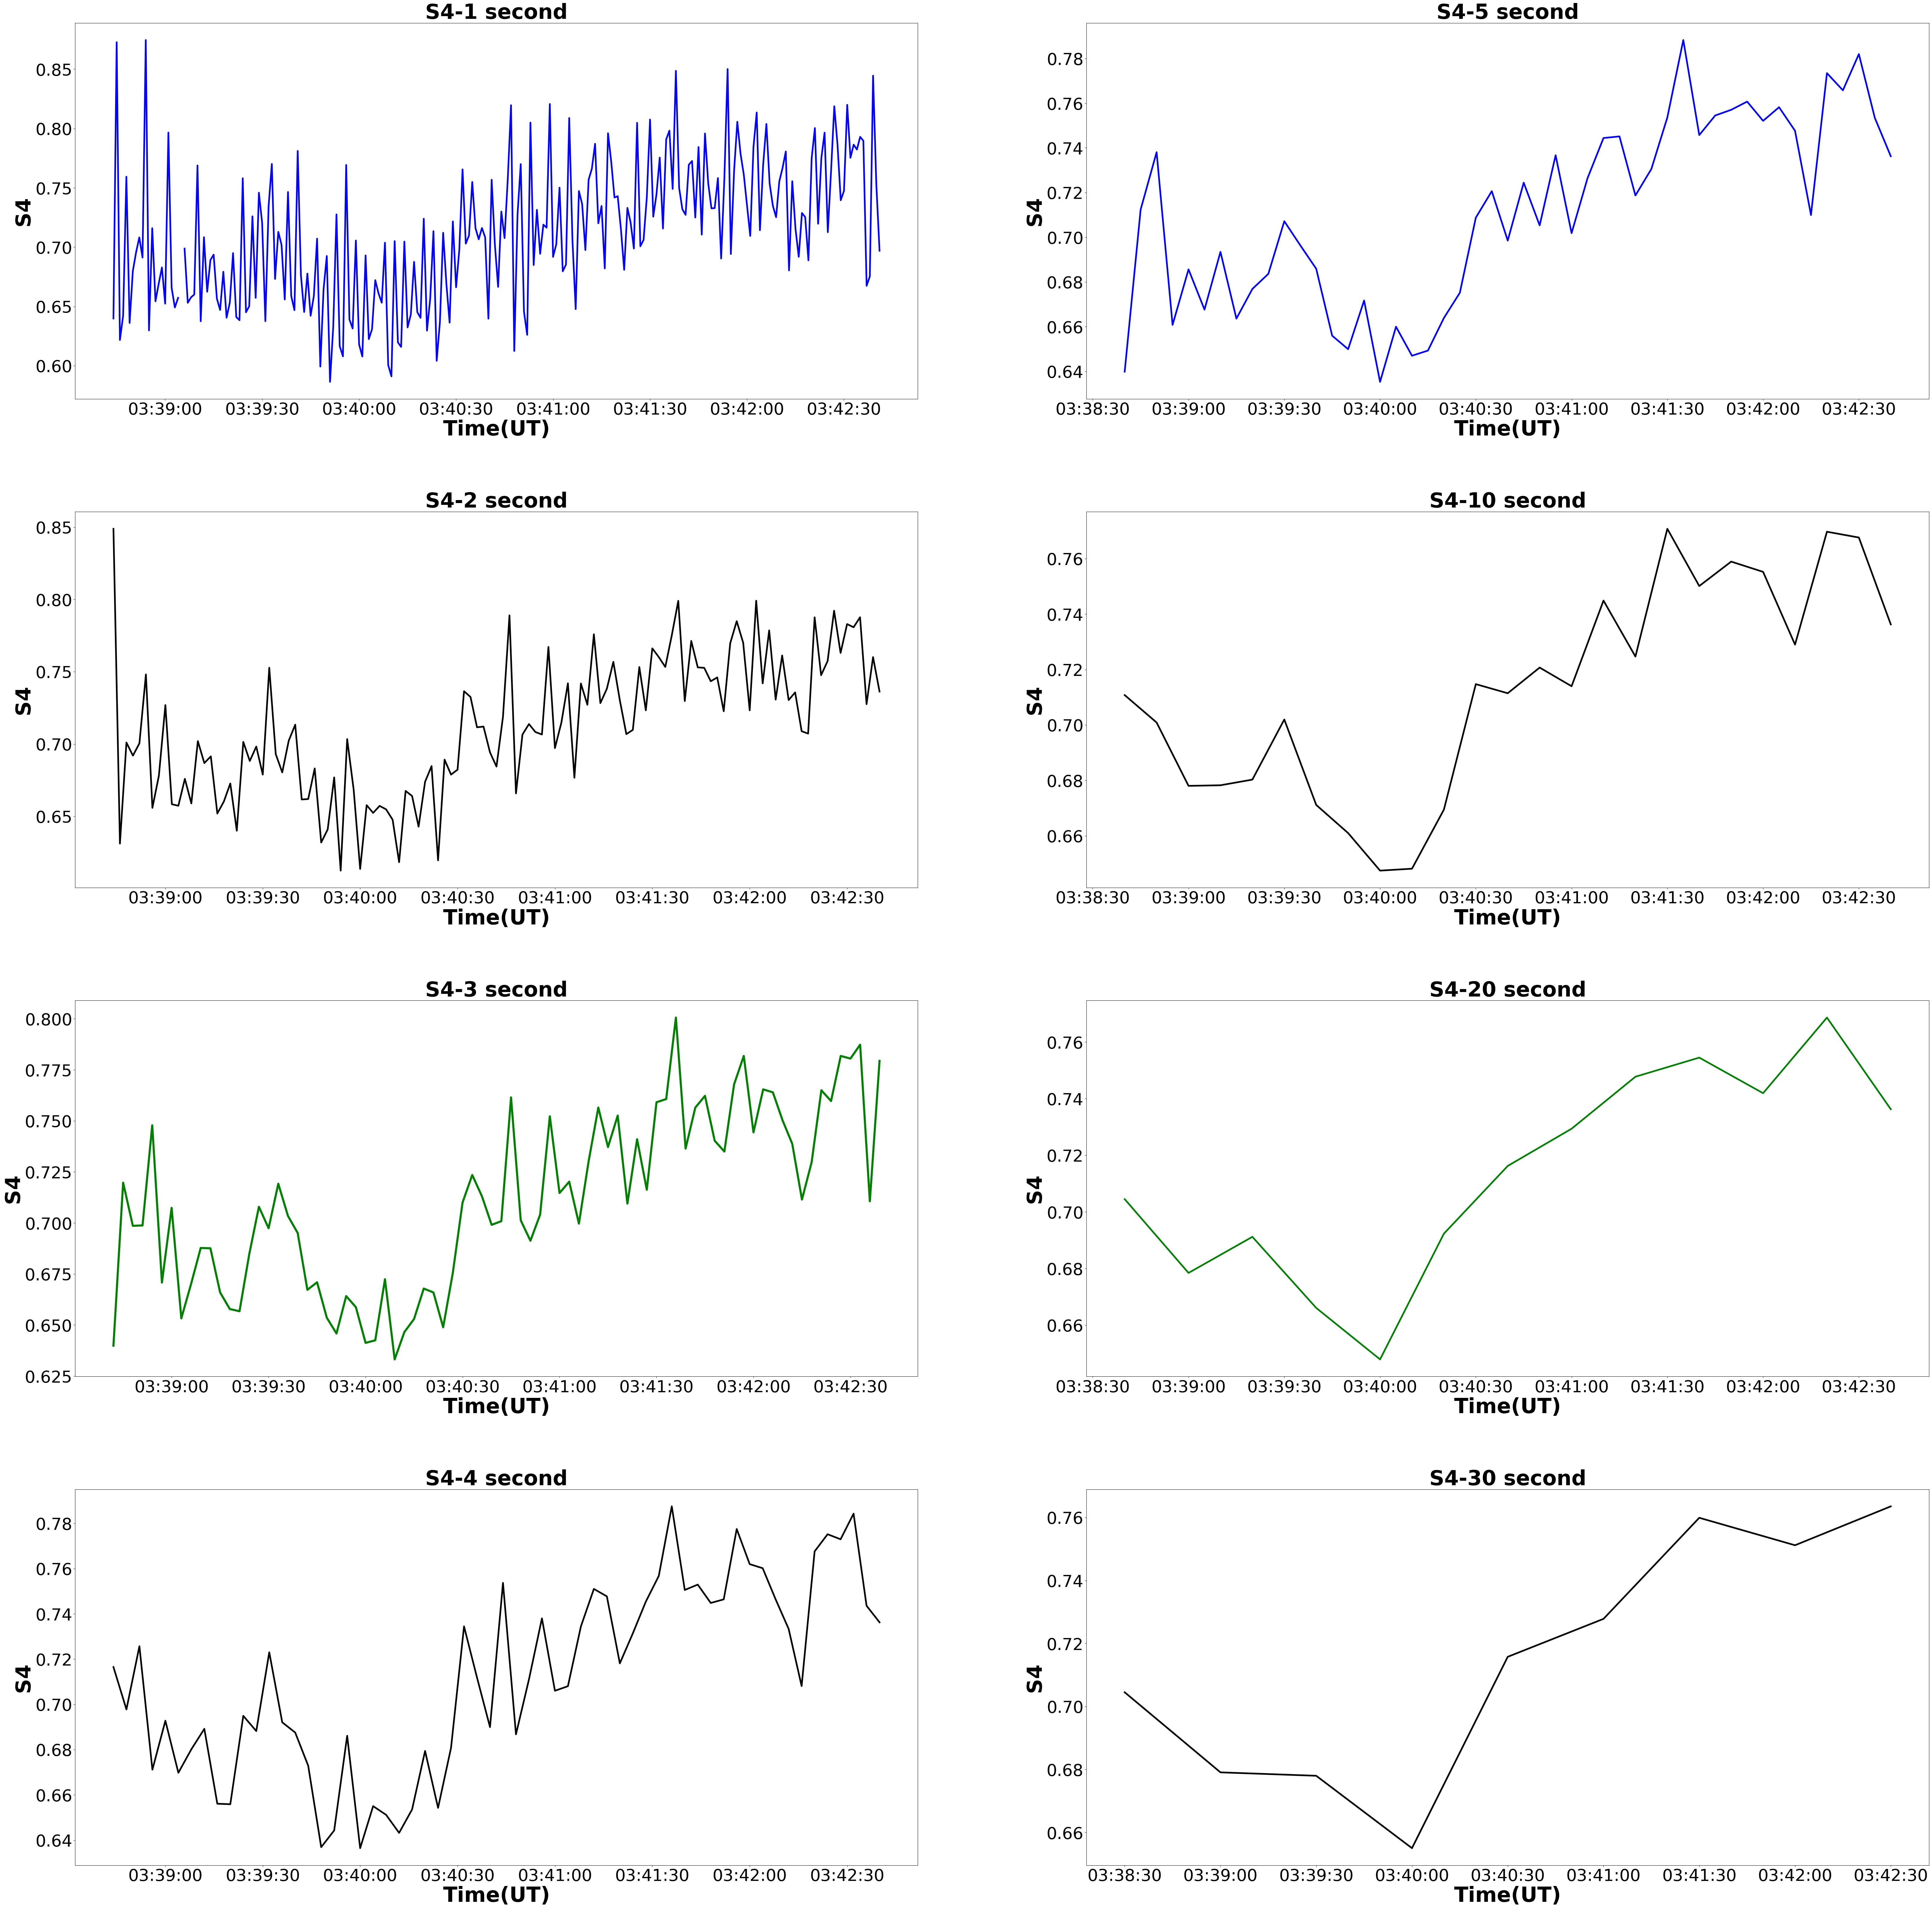

In [ ]:

fig, axs = plt.subplots(4, 2, figsize=(80, 80))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Subplot 1
axs[0,0].plot(df_subset_[0]['time'], s4_values_all[0], color='blue', linewidth=4)
axs[0,0].set_title('S4-1 second', fontsize=50, fontweight='bold')
axs[0,0].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[0,0].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[0,0].tick_params(axis='both', labelsize=40)

# Subplot 2
axs[1,0].plot(df_subset_[1]['time'], s4_values_all[1], color='black', linewidth=4)
axs[1,0].set_title('S4-2 second', fontsize=50, fontweight='bold')
axs[1,0].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[1,0].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[1,0].tick_params(axis='both', labelsize=40)

# Subplot 3
axs[2,0].plot(df_subset_[2]['time'], s4_values_all[2], color='green', linewidth=5)
axs[2,0].set_title('S4-3 second', fontsize=50, fontweight='bold')
axs[2,0].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[2,0].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[2,0].tick_params(axis='both', labelsize=40)

# Subplot 4
axs[3,0].plot(df_subset_[3]['time'], s4_values_all[3], color='black', linewidth=4)
axs[3,0].set_title('S4-4 second', fontsize=50, fontweight='bold')
axs[3,0].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[3,0].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[3,0].tick_params(axis='both', labelsize=40)

# Subplot 5
axs[0,1].plot(df_subset_[4]['time'], s4_values_all[4], color='blue', linewidth=4)
axs[0,1].set_title('S4-5 second', fontsize=50, fontweight='bold')
axs[0,1].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[0,1].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[0,1].tick_params(axis='both', labelsize=40)

# Subplot 6
axs[1,1].plot(df_subset_[9]['time'], s4_values_all[9], color='black', linewidth=4)
axs[1,1].set_title('S4-10 second', fontsize=50, fontweight='bold')
axs[1,1].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[1,1].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[1,1].tick_params(axis='both', labelsize=40)

# Subplot 7
axs[2,1].plot(df_subset_[19]['time'], s4_values_all[19], color='green', linewidth=4)
axs[2,1].set_title('S4-20 second', fontsize=50, fontweight='bold')
axs[2,1].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[2,1].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[2,1].tick_params(axis='both', labelsize=40)

# Subplot 8
axs[3,1].plot(df_subset_[29]['time'], s4_values_all[29], color='black', linewidth=4)
axs[3,1].set_title('S4-30 second', fontsize=50, fontweight='bold')
axs[3,1].set_xlabel('Time(UT)', fontsize=50, fontweight='bold')
axs[3,1].set_ylabel('S4', fontsize=50, fontweight='bold')
axs[3,1].tick_params(axis='both', labelsize=40)

plt.show()


# Elevation angle  and dipole voltage veriation with time

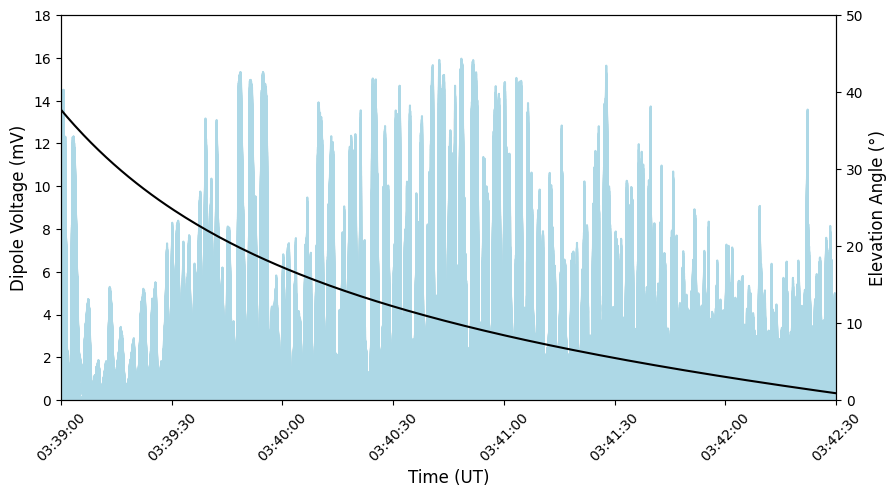

In [ ]:

fig, ax_main = plt.subplots(figsize=(10, 5))

bar1 = ax_main.plot(time_1[x], n1, color='lightblue')
ax_main.set_xlabel("Time (UT)", fontsize=12)
ax_main.set_ylabel("Dipole Voltage (mV)", fontsize=12)
ax_main.set_xlim(left=pd.Timestamp('2015-04-01 03:39:00'),right=pd.Timestamp('2015-04-01 03:42:30'))
ax_main.set_ylim(0, 18)
plt.tick_params(axis='both', labelsize=10)
ax_main.tick_params(axis='x', labelrotation=45, color='black')

ax2 = ax_main.twinx()
bar2 = ax2.plot(time_1[x], elev[x], color='black')
ax2.set_ylabel("Elevation Angle (°)", fontsize=12)
ax2.set_ylim(0, 50)
ax2.grid(visible=False)

#plt.title("Dipole Voltage 2015-04-03 Frequency=11.205120 MHz", fontsize=20)
plt.tick_params(axis='both', labelsize=10)

plt.show()

The phenomenon you described is known as ionospheric scintillation. Ionospheric scintillation refers to rapid fluctuations in the amplitude and phase of radio waves passing through the Earth's ionosphere. These fluctuations are caused by irregularities in the electron density distribution within the ionosphere. The severity of scintillation effects depends on various factors, including elevation angle, frequency of the radio wave, and the level of electron density irregularities.

As you mentioned, at lower elevation angles, the radio waves traverse a longer path through the ionosphere, encountering a greater effective thickness of the ionosphere. This means that smaller fractional deviations in electron content over greater distances can lead to significant scintillation effects at low elevations.

In contrast, at higher elevation angles, the radio waves pass through a smaller thickness of the ionosphere and traverse a shorter distance, resulting in fewer and less severe scintillation effects.

Overall, the combination of increased effective thickness of the ionosphere  at lower elevation angles makes scintillations more common and intense compared to higher elevation angles. This phenomenon has been observed and documented in various experimental studies, confirming the relationship between elevation angle and the occurrence of ionospheric scintillation.